# Overview

this notebook runs the models and save the time and score
the saved dataframe can be found in `../data/processed/results_{date}`

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")
from src.graph import NetworkGraph

In [55]:
import time
import gurobi
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

In [4]:
from src.flows import *
from src.models.DQL.DQL import run

In [5]:
from flatland.envs.rail_env import RailEnv
from flatland.envs.observations import *
from flatland.envs.rail_generators import complex_rail_generator,rail_from_manual_specifications_generator,random_rail_generator, RailGenerator
from flatland.envs.schedule_generators import complex_schedule_generator, random_schedule_generator, ScheduleGenerator
from flatland.utils.rendertools import RenderTool

### Helper functions

In [6]:
def create_env(height,width,seed,number_of_agents=4):
    env = RailEnv(width=width,
              height=height,
              rail_generator=complex_rail_generator(nr_start_goal=20, nr_extra=1, 
                                                    min_dist=6, max_dist=99999, seed = seed),
              schedule_generator=complex_schedule_generator(),
              number_of_agents=number_of_agents)
    
    
    
    return env

In [7]:
def run_flow(env,height,width):
    
    #extract the transition matrix
    matrix_rail = np.array(env.rail.grid.tolist())
    
    #build the transition network
    flatlandNetwork = NetworkGraph(matrix_rail)

    #get the sources and sinks of the different agents
    sources = []
    sinks = []
    for agent in env.agents:
        sources.append(agent.initial_position)
        sinks.append(agent.target)
        
    #build the time exanded network and connect the sources and sinks
    TestNetworkTime = TimeNetwork(flatlandNetwork, depth=max(2*(height+width),40))
    TestNetworkTime.connect_sources_and_sink(sources,sinks)
    
    
    #get the Integral Program formulation of the problem and solve it 
    print(sources,sinks)
    mcflow = MCFlow(TestNetworkTime.graph,len(sources),TestNetworkTime.topology)
    mcflow.solve()
    
    #extract the path and compute the scores (total time spent by the agent in the grid)
    cost= 0
    if not mcflow.check_if_feasible():
        return "Infeasible"
    print(mcflow.m.objVal)
    paths = mcflow.extract_paths()
    for agent,path in paths.items():
        print(path)
        cost += -1+len(path)/2
       
    return cost

In [8]:
def run_flow_rl(env,width,height,seed,n_start_goal=20,initial_value = 0,
             learning_rate = 0.8,gamma = 0.9,epsilon = 0.1,threshold = 0.3):
    number_agents = len(env.agents)
    n_episodes = width*height*number_agents*15
    n_steps = 2*(width+height)
    print(seed)
    cost, n_episodes, total_time = run(number_agents,
                                    width,height,
                                    n_start_goal,
                                    seed,
                                    n_episodes,
                                    n_steps,
                                    initial_value,
                                    learning_rate,
                                    gamma,
                                    epsilon,
                                    threshold)
    
    return cost, n_episodes, total_time

In [9]:
def run_experiment_and_save_results(method, results,agents = 4, repetition = 5, 
                                    pathToSavedGrids = None, grids_size = None):
    nodes = []
    edges = []
    sizes_list = []
    if pathToSavedGrids is None:
        for sizes in tqdm(grids_size):
            for i in range(repetition):
                seed = sizes[0]*sizes[1]+i
                print(f'seed {seed}')
                env = create_env(sizes[0],sizes[1],seed,number_of_agents=agents)
                
                env.step({0:2})
                env_renderer = RenderTool(env,agent_render_variant=3)
                env_renderer.render_env(show=True, show_predictions=False, show_observations=False)
                env = create_env(sizes[0],sizes[1],seed,number_of_agents=agents)
    
                start = time.time()
                cost = run_flow(env,sizes[0],sizes[1])
                print(cost)
                sizes_list.append(sizes[0]*sizes[1])                    
                time_spent = time.time()-start
                results = results.append({'Size of the grid' : sizes[0]*sizes[1] , 
                                          'Score' : cost, "Time":time_spent, 
                                          "Type":"CO","Number of episodes": None} , 
                                         ignore_index=True)
                results.to_csv("../data/processed/results_comparison"+str(agents)+".csv")
                start = time.time()
                cost, n_episodes, total_time = run_flow_rl(env,sizes[1],sizes[0],seed)
                print(cost)
                sizes_list.append(sizes[0]*sizes[1])                    
                time_spent = time.time()-start
                results = results.append({'Size of the grid' : sizes[0]*sizes[1] , 
                                          'Score' : cost, "Time":time_spent, "Number of episodes": n_episodes,
                                          "Type":"RL"} , 
                                         ignore_index=True)
                results.to_csv("../data/processed/results_comparison.csv")
                print("---")
                
                env_renderer.close_window()
                
    else:
        raise NotImplementedError("Load the map and proceed to inference")

### Constant definition

In [10]:
grids_size = [(10,5),(10,10),(15,10),(15,15),(20,15),(20,20),(25,20),
              (25,25),(25,30),(30,30),(35,30), (35,35),(40,35),(40,40),
              (45,40),(45,45),(50,50),(55,50),(55,55),(60,55),(60,60),
              (65,60),(65,65),(70,65),(70,70),(75,70),(75,75),(80,75),
             (80,80),(85,90),(90,90),(95,90),(95,95),(100,95),(100,100)]

In [14]:
results = pd.DataFrame()

## Actual run

In [16]:
run_experiment_and_save_results(run_flow, results, agents = 2, repetition=4, grids_size=grids_size)



  0%|          | 0/35 [00:00<?, ?it/s]

seed 50
[(1, 2), (6, 3)] [(9, 0), (0, 0)]
Optimize a model with 35674 rows, 26068 columns and 97884 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 34769 rows and 24151 columns
Presolve time: 0.05s
Presolved: 905 rows, 1917 columns, 3830 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.913e+03
 Factor NZ  : 1.569e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.134e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.60710608e+04 -3.69813431e+04  4.18e+02 6.32e+00  2.39e+02     0s
   1   7.35570607e+03 -3.33442432e+04  1.16e+02 1.78e-14  6.81e+01     0s
   2   1.52900622e+03 -2.20970881e+04  2.18e+01 5.33e-14  1.53e+01

3.8452685107021254
2.649264402125825
1.487943274745315
0.9281460467663295
1.0758090611158164
0.853929237180858
1.0935315376035104
1.0558029625141447
0.6717645991724503
0.4868014613389752
0.4925136161359017
0.4633971240518631
0.7299933287556276




  3%|▎         | 1/35 [27:51<15:47:17, 1671.68s/it]

23
---
seed 100
[(1, 0), (0, 2)] [(8, 4), (9, 9)]
Optimize a model with 70378 rows, 51348 columns and 192924 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 69800 rows and 50125 columns
Presolve time: 0.07s
Presolved: 578 rows, 1223 columns, 2442 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.219e+03
 Factor NZ  : 9.176e+03 (roughly 1 MByte of memory)
 Factor Ops : 1.624e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.08 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 383 iterations and 0.09 seconds
Optimal objective  5.200000000e+01
52.0
['source_agent_0', '(1, 0)_S_out_t0', '(2, 0)_N_in_t1', '(2, 0)_S_out_t2', '(3, 0)_N_in_t3', '(3, 0)_S_out_t4', '

0.2568192
0.132932768
0.2636112295744001
0.10189164162844147
0.22737646500351275
0.006954626510307804
0.04264341513348764
0.2158285977314685
0.19726518908476467
0.00856953499346254
21
---
seed 103
[(6, 1), (1, 7)] [(5, 7), (8, 3)]
Optimize a model with 52138 rows, 38068 columns and 143004 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 51251 rows and 36184 columns
Presolve time: 0.05s
Presolved: 887 rows, 1884 columns, 3764 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.880e+03
 Factor NZ  : 1.561e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.118e+05 (less than 1 second per iteration)
 Threads    : 1

Barrier performed 0 iterations in 0.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 341 



  6%|▌         | 2/35 [1:34:15<21:40:59, 2365.43s/it]

18
---
seed 150
[(4, 9), (8, 3)] [(0, 2), (13, 8)]
Optimize a model with 124072 rows, 90584 columns and 340352 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 122585 rows and 87456 columns
Presolve time: 0.11s
Presolved: 1487 rows, 3128 columns, 6252 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.124e+03
 Factor NZ  : 2.647e+04 (roughly 2 MBytes of memory)
 Factor Ops : 5.625e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.32505457e+04 -7.35858813e+04  6.34e+02 8.18e+00  2.83e+02     0s
   1   1.23115145e+04 -6.64637228e+04  1.77e+02 2.84e-14  8.19e+01     0s
   2   2.62709121e+03 -4.46164473e+04  3.52e+01 7.82

   1   1.14549855e+04 -6.85862787e+04  1.21e+02 2.13e-14  5.58e+01     0s
   2   3.12668961e+03 -3.92777955e+04  3.06e+01 6.22e-14  1.46e+01     0s
   3   6.57502536e+02 -1.05670535e+04  4.80e+00 9.68e-14  2.69e+00     0s
   4   1.57097398e+02 -2.14136413e+03  3.97e-01 8.17e-14  4.11e-01     0s
   5   1.14447837e+02 -8.27587561e+02  1.33e-01 5.86e-14  1.44e-01     0s
   6   9.53077704e+01 -3.07632043e+02  2.23e-02 4.26e-14  5.40e-02     0s
   7   8.55517922e+01 -5.66220036e+01  4.09e-05 2.49e-14  1.84e-02     0s
   8   7.59420032e+01 -1.77009051e+01  7.74e-06 1.89e-14  1.21e-02     0s
   9   6.46278465e+01  9.31707868e+00  2.15e-06 1.17e-14  7.18e-03     0s
  10   5.32485952e+01  8.84768871e+00  9.42e-07 1.42e-14  5.76e-03     0s
  11   4.28871611e+01  2.83043777e+01  1.73e-07 7.11e-15  1.89e-03     0s
  12   3.69204370e+01  3.41881106e+01  1.28e-08 7.11e-15  3.54e-04     0s
  13   3.60648113e+01  3.59827510e+01  2.78e-10 5.33e-15  1.06e-05     0s
  14   3.60000648e+01  3.59999824e+01 



  9%|▊         | 3/35 [3:28:30<32:59:50, 3712.21s/it]

22
---
seed 225
[(3, 0), (12, 9)] [(2, 14), (4, 8)]
Optimize a model with 249974 rows, 183100 columns and 688500 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 246751 rows and 176243 columns
Presolve time: 0.26s
Presolved: 3223 rows, 6857 columns, 13728 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.887e+03
 Factor NZ  : 7.865e+04 (roughly 5 MBytes of memory)
 Factor Ops : 3.695e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.20528704e+04 -2.18108737e+05  4.95e+02 1.33e+01  4.25e+02     0s
   1   2.95744827e+04 -1.98189972e+05  1.56e+02 3.91e-14  1.36e+02     0s
   2   6.38893027e+03 -1.45015704e+05  3.14e+01 

226
1.8633875710279684
1.6715191222272
1.7610001612800006
2.0130902192277005
1.8023447324524549
1.798709162994523
2.0239733555200004
1.5528574336336107
1.3431629414400001
1.8790478000947202
1.3936066560000002
2.520699453012593
1.8069014118400002
1.5215922380800004
1.6430297652208967
1.5505899061248
1.655640351624397
1.1918224476078079
2.1461032960000006
1.7529731481600002
1.2243994396874305
1.3632307200000002
1.3188825211404813
0.8594480617348803
1.8633517959561021
1.621308851355648
1.7551010693120004
2.2175166038016
2.1417238528
1.7915883755751343
1.2750132007830361
1.0064747102208
1.038869131815575
1.77375780755469
0.9139200000000001
1.9163308032000002
1.5896744174675108
1.0783744000000002
1.559391621721411
1.511924912147661
0.6873629422767725
1.0976682812622451
1.5958993011214053
1.227670561895408
1.2026060349841254
1.4134239226825471
1.3220686685798402
1.1346958368821445
1.9098624000000004
2.9685242015774174
0.8991507457767347
1.144446634164224
1.0809316769090107
1.8114279277225578

19.0
228
3.929526390625063
2.537109827753244
5.498348844581369
2.1179211186176
1.97128192
2.4698241024000005
2.828661301706752
3.1469123217196167
2.395361633975742
2.0134672203776005
2.596054598975884
1.5246313336595407
2.0255112635133155
2.438570954981376
2.68065643311396
1.9212854580998797
2.394443939840001
1.037795390011886
1.6283648000000006
1.7156846059520001
1.161459380667026
1.559371609579222
1.419254197109062
2.4689414315704323
1.561153072350194
1.0893497903383094
1.662233106794414
1.629736156578726
2.1604581572608
1.3164625920000004
0.8331436328222719
0.24985600000000005
0.5975818108254733
0.45662415033571746
0.4802051334366751
0.8077070237554289
0.7138809012674681
0.6487490092445719
1.3394745163776
0.3155718179881181
1.1290011931928168
0.24224118533521413
1.9878092800000005
0.29952000000000006
0.29184000000000004
0.22054733279957656
0.7886785970598588
1.1977201621425462
0.7860838238428536
0.18778112
0.3907687590102303
0.3175951569111243
0.30580598033906403
0.21383535001600001



 11%|█▏        | 4/35 [6:59:38<55:06:07, 6398.95s/it]

20
---
seed 300
[(17, 1), (9, 12)] [(10, 10), (18, 14)]
Optimize a model with 439128 rows, 321976 columns and 1210928 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 434312 rows and 312305 columns
Presolve time: 0.40s
Presolved: 4816 rows, 9671 columns, 19960 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.100e+04
 Factor NZ  : 1.239e+05 (roughly 7 MBytes of memory)
 Factor Ops : 5.594e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.43204408e+05 -2.49011118e+05  9.77e+02 9.54e+00  3.83e+02     0s
   1   4.05183137e+04 -2.34153040e+05  2.71e+02 2.84e-14  1.10e+02     0s
   2   1.11515419e+04 -1.65678370e+05  7.07

23.0
301
1.0718959877960499
1.1842560000000002
0.58927417524224
2.2063713091584005
2.0907417600000002
1.9366231408640004
2.127048081408
1.6431209399961801
1.5510079629878835
1.6787399669448704
2.2867558400000005
1.7386417343676193
0.8174389423279398
2.5037979619164163
2.9177749503999997
2.438915693341573
2.1824153452544
1.9445147197924968
1.3399270894151316
1.7073885845913603
1.6893282070707099
1.6516792320000002
2.263715625900494
1.613629505972896
2.30977536
1.8332876800000002
1.3643277926400001
1.9922074325821166
1.59484302420586
1.9155331803962883
1.3684899840000002
1.4379048960000005
1.4727241866936318
1.8532042055195037
1.0658816000000002
2.430134711484416
1.0998367429328213
1.6102791173898243
1.692704396213508
1.0310365355704318
1.2390400000000001
0.35618258602865516
1.029817873585855
2.0942414812022836
0.5230255781308708
0.3986882560000001
2.02617995264
1.1279322444881992
0.3493737761751643
1.4425843831515661
0.3544638685184001
0.26036904263680005
1.7103011840000002
0.8383810673


Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.356e+04
 Factor NZ  : 1.715e+05 (roughly 10 MBytes of memory)
 Factor Ops : 8.457e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.69700947e+05 -4.52355514e+05  1.21e+03 0.00e+00  6.09e+02     0s
   1   6.73084642e+04 -4.30174576e+05  2.99e+02 3.55e-14  1.59e+02     0s
   2   1.96291215e+04 -3.13272276e+05  8.40e+01 1.31e-13  4.63e+01     0s
   3   5.06302690e+03 -1.21343858e+05  2.02e+01 2.84e-13  1.10e+01     0s
   4   1.18142731e+03 -2.58391540e+04  3.67e+00 2.52e-13  2.16e+00     0s
   5   4.03362999e+02 -8.61781236e+03  5.88e-01 2.11e-13  6.00e-01     0s
   6   1.96639775e+02 -3.49630807e+03  1.26e-01 2.63e-13  1.84e-01     0s
   7   1.48688131e+02 -1.00321496e+03  3.17e-02 1.37e-13  4.90e-02     0s
   8   1.33229493e+02 -2.65529787e+02  7.02e-03 9.67e-14  1.52e-02     0s
   9   1.25



 14%|█▍        | 5/35 [9:49:24<62:47:27, 7534.92s/it]

29
---
seed 400
[(15, 12), (2, 1)] [(19, 6), (7, 14)]
Optimize a model with 507354 rows, 370852 columns and 1393516 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 499325 rows and 353928 columns
Presolve time: 0.46s
Presolved: 8029 rows, 16924 columns, 33844 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.692e+04
 Factor NZ  : 2.320e+05 (roughly 12 MBytes of memory)
 Factor Ops : 1.387e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.46212775e+05 -5.38232065e+05  1.23e+03 4.00e+00  5.89e+02     1s
   1   9.95775800e+04 -4.98442060e+05  3.50e+02 3.55e-14  1.70e+02     1s
   2   2.13063384e+04 -3.78701935e+05  7.15


       0 PPushes remaining with PInf 0.0000000e+00                 1s

  Push phase complete: Pinf 0.0000000e+00, Dinf 0.0000000e+00      1s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    7083    4.8000000e+01   0.000000e+00   0.000000e+00      1s

Solved with dual simplex
Solved in 1247 iterations and 0.77 seconds
Optimal objective  4.800000000e+01
48.0
['source_agent_0', '(12, 15)_E_in_t1', '(12, 15)_W_out_t2', '(12, 14)_E_in_t3', '(12, 14)_W_out_t4', '(12, 13)_E_in_t5', '(12, 13)_N_out_t6', '(11, 13)_S_in_t7', '(11, 13)_W_out_t8', '(11, 12)_E_in_t9', '(11, 12)_N_out_t10', '(10, 12)_S_in_t11', '(10, 12)_W_out_t12', '(10, 11)_E_in_t13', '(10, 11)_N_out_t14', '(9, 11)_S_in_t15', '(9, 11)_W_out_t16', '(9, 10)_E_in_t17', '(9, 10)_N_out_t18', '(8, 10)_S_in_t19', '(8, 10)_W_out_t20', '(8, 9)_E_in_t21', '(8, 9)_N_out_t22', '(7, 9)_S_in_t23', 'sink_agent_0']
['source_agent_1', '(6, 5)_S_out_t0', '(7, 5)_N_in_t1', '(7, 5)_S_out_t2', '(8, 5)_N_in_t3', '(8, 5)_S_out_t4', 

0.19456000000000004
1.2535749046477784
0.669324223184896
0.13568000000000002
0.2865996511377855
0.18176000000000003
0.5610599526734381
0.17408
0.28391111478481085
0.23594017224595157
0.2500417145782254
1.3847388160000003
0.5725139891601908
0.24590783610880002
0.6456888398643855
0.6826021368627201
0.9113198477352364
0.5686369981334402
0.8137822696167877
0.5028498927901458
0.19917011163447434
0.19147571200000005
0.09205760000000003
0.12986592691943474
0.256
0.20537344000000005
0.20344779261870088
0.8607518581887956
1.9142236569600002
0.4614306123113364
0.22735765504000002
0.23477288960000003
0.4004704187853828
0.7339958054522201
0.128
0.5624315197102611
0.12288000000000002
0.13568000000000002
0.23052632284281926
0.1156257184987755
0.19184435200000005
0.17408
0.15077752832000002
0.13568000000000002
0.2189189120000001
0.22587664004102642
0.20067696640000002
0.5851896907779056
0.11687575552000004
1.4340329301978159
0.16167113392945892
0.17408
0.2241536
0.5750696445181755
0.6358600530796157




 17%|█▋        | 6/35 [12:51:08<68:50:29, 8545.84s/it]

41
---
seed 500
[(23, 1), (8, 7)] [(17, 14), (13, 13)]
Optimize a model with 628144 rows, 458968 columns and 1724304 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 613341 rows and 427964 columns
Presolve time: 0.58s
Presolved: 14803 rows, 31004 columns, 62004 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.100e+04
 Factor NZ  : 4.497e+05 (roughly 20 MBytes of memory)
 Factor Ops : 3.030e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.19779655e+05 -1.33869576e+06  1.38e+03 1.93e+01  8.01e+02     1s
   1   1.91846288e+05 -1.25275639e+06  4.22e+02 5.68e-14  2.50e+02     1s
   2   4.62750457e+04 -9.90544535e+05  9.


Crossover log...

       0 DPushes remaining with DInf 0.0000000e+00                 1s

       1 PPushes remaining with PInf 0.0000000e+00                 1s
       0 PPushes remaining with PInf 0.0000000e+00                 1s

  Push phase complete: Pinf 0.0000000e+00, Dinf 0.0000000e+00      1s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15124    7.4000000e+01   0.000000e+00   0.000000e+00      2s

Solved with barrier
Solved in 15124 iterations and 1.71 seconds
Optimal objective  7.400000000e+01
74.0
['source_agent_0', '(22, 7)_S_in_t1', '(22, 7)_W_out_t2', '(22, 6)_E_in_t3', '(22, 6)_N_out_t4', '(21, 6)_S_in_t5', '(21, 6)_W_out_t6', '(21, 5)_E_in_t7', '(21, 5)_N_out_t8', '(20, 5)_S_in_t9', '(20, 5)_W_out_t10', '(20, 4)_E_in_t11', '(20, 4)_N_out_t12', '(19, 4)_S_in_t13', '(19, 4)_W_out_t14', '(19, 3)_E_in_t15', '(19, 3)_N_out_t16', '(18, 3)_S_in_t17', '(18, 3)_W_out_t18', '(18, 2)_E_in_t19', '(18, 2)_N_out_t20', '(17, 2)_S_in_t21', '(17, 2)_W_out_t22', '(17

KeyboardInterrupt: 

# PLOTS

In [17]:
df = pd.read_csv("../data/processed/results_comparison2.csv", index_col = 'Unnamed: 0')

In [18]:
df

,Number of episodes,Score,Size of the grid,Time,Type
0,NaN,18.5,50.0,2.893524,CO
1,-1.0,19.0,50.0,412.162223,RL
2,NaN,17.0,50.0,2.601275,CO
3,-1.0,17.0,50.0,406.810648,RL
4,NaN,16.5,50.0,2.451683,CO
5,-1.0,17.0,50.0,413.099345,RL
6,NaN,20.5,50.0,2.399273,CO
7,-1.0,23.0,50.0,422.627614,RL
8,NaN,27.0,100.0,5.644670,CO
9,-1.0,28.0,100.0,942.511821,RL


In [37]:
rl_values = df[df.Type == "RL"].Score.values
sizes = df[df.Type == "RL"]["Size of the grid"].values
co_values = df[df.Type == "CO"].Score.values[:-1]
diff = rl_values-co_values


In [38]:
diff[diff == 0.5] = 1

In [39]:
diff[diff == 2.5] = 3

In [40]:
diff[diff == 3.5] = 4

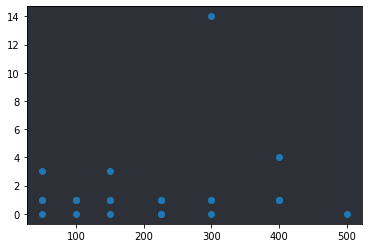

In [41]:
plt.scatter(sizes,diff)

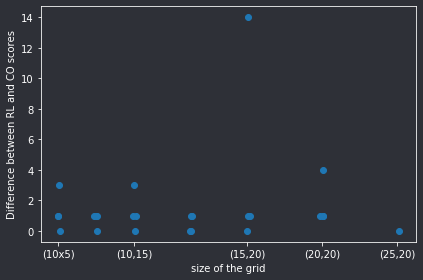

In [65]:
plt.rcParams['savefig.facecolor'] = (46/255., 48/255., 55/255.)
plt.rcParams['axes.facecolor'] = (46/255., 48/255., 55/255.)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.spines['bottom'].set_color("white")
ax.spines['top'].set_color("white") 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
fig.set_facecolor((46/255., 48/255., 55/255.))
ax.set_facecolor((46/255., 48/255., 55/255.))


#plt.scatter(df[df.Type == 'CO']['Size of the grid'].values[:-1],df[df.Type == 'CO'].Score.values[:-1],label = "CO")
#plt.scatter(df[df.Type == 'RL']['Size of the grid'],df[df.Type == 'RL'].Score, label = "RL")
sizes_jitter = [np.random.normal(x, 2,1) for x in sizes]
plt.scatter(sizes_jitter,diff)
plt.xlabel("size of the grid")

x1 = [50,150,15*20,400,500]
squad = ['(10x5)','(10,15)','(15,20)','(20,20)','(25,20)']

ax.set_xticks(x1)
ax.set_xticklabels(squad)

plt.ylabel("Difference between RL and CO scores")

#l = plt.legend()
#for text in l.get_texts():
#    text.set_color("white")



ax = plt.gca()
plt.tight_layout()
plt.savefig("../data/processed/comparison_1.png", dpi = 300)

In [ ]:
df_20_agents = pd.read_csv("../data/processed/results_20_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
df_10_agents = pd.read_csv("../data/processed/results_10_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
df_4_agents = pd.read_csv("../data/processed/results_4_agents.csv",index_col = 'Unnamed: 0')

In [ ]:
plt.rcParams['savefig.facecolor'] = (46/255., 48/255., 55/255.)
plt.rcParams['axes.facecolor'] = (46/255., 48/255., 55/255.)
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.spines['bottom'].set_color("white")
ax.spines['top'].set_color("white") 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.title.set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
fig.set_facecolor((46/255., 48/255., 55/255.))
ax.set_facecolor((46/255., 48/255., 55/255.))


plt.scatter(df_4_agents['Size of the grid'],df_4_agents['Time'].values/60, label = "4 trains",alpha= 0.8)
plt.scatter(df_10_agents['Size of the grid'],df_10_agents['Time'].values/60, label = "10 trains",alpha = 0.8)
plt.scatter(df_20_agents['Size of the grid'],df_20_agents['Time'].values/60, label = "20 trains",alpha = 0.8)


plt.xlabel("size of the grid (number of cells)")

x1 = [20**2,40**2,50*50,60*60]
squad = ['(20x20)','(40x40)','(50,50)','(60x60)']

ax.set_xticks(x1)
ax.set_xticklabels(squad)

plt.ylabel("time until solution (min)")
#plt.title("Experiment of multicommodity flow formulation until memory error (model > 40 Gb)")

l = plt.legend()
for text in l.get_texts():
    text.set_color("white")



ax = plt.gca()
plt.tight_layout()
plt.savefig("../data/processed/time.png", dpi = 300)